# 논문 소개

- stock price prediction using BERT and GAN
    - 기간 : 2010년 7월부터 2020년 7월까지
    - ARIMA : closing 데이터만 사용 => ARIMA((4,1,0)
    - 다른 모델의 데이터 : technical indicators : moving average, bollinger Bands, Moving Average Convergence Divergence, RSI, Fourier transforms, NYSE, NASDAQ, S&P 500, stock exchange index(London, india, tokyo, hong kong, shanghai, chicage), oil, gold, us-dollar, google, amazon, microsoft

In [2]:
import pandas as pd
import numpy as np
import regex as re
    
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')
import itertools

import datetime

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
year = list(map(str, list(range(2017,2023))))
month = list(map(str, list(range(1,13))))

for i in range(0,9):
    month[i] = "0"+month[i]

year_month = [0]*(12*5+4)

k=0
for i in range(len(year)):
    for j in range(len(month)):
        if k < len(year_month):
            year_month[k] = year[i]+"_"+month[j]
            k = k+1
        else:
            k=k+1

In [3]:
## 소문자 변환 - tit, txt에 적용(text, title을 토큰화한 리스트)
def upper_to_lower_line(line):  ## 한 리스트의 한 문장씩 불러와서 upper_to_lower_word 적용
    line = list(map(upper_to_lower_word,line))
    return line

def upper_to_lower_word(word):  ## string 형식, 한 문장의 한 단어씩 불러와서 대문자 변환   The -> the, THE -> THE
    word = re.sub("^[A-Z]{1}[a-z]*$",word.lower(),word)  ## 정규표현식에 맞는 단어만 lower 적용
    return word





## 표제어 추출 - tit, txt에 적용
def lemmatization_line(line):   ## 한 리스트의 한 문장씩 불러와서 lemmatization_line 적용
    line = list(map(lemmatization_word, line))
    return line

def lemmatization_word(data):  ## string 형식, 한 문장의 한 단어씩 불러와서 표제어 추출
    n=WordNetLemmatizer()
    data = n.lemmatize(data)
    return data





## 불용어 제거 - tit, txt에 적용
def del_stopword(line):              ## 한 리스트의 한 문장씩 불러와서 dir_stopword_produce 적용
    dir_stop_words = stopwords.words('english')  ## 불용어 사전
    
    line_stopwords_intersection = list(set(line)& set(dir_stop_words))   ## 각 문장과 불용어 사전에 동시에 있는 단어 추출
    
    # 각 문장마다 불용어 사전과 교집합인 사전 생성
    
    # 각 문장마다 교집합 사전에 해당하지 않는 값만 추출
    line = difference(line, line_stopwords_intersection)  
    
    return line


def difference(line, line_stopwords_intersection):      ## 각 문장, 각 문장과 불용어 사전의 교집합 입력
    line = [i for i in line if i not in line_stopwords_intersection]  ## 불용어 사전에 해당하지 않는 단어만 추출
    return line






dir = "C:/Users/default.DESKTOP-IT64657/Desktop/nbc/"

def loading(data):

    ## ----------------------데이터 파일 불러오기--------------------------------------------------
    f = open(dir+str(data)+".txt","r", encoding = "UTF-8")
    datas = f.readlines()
    f.close()
    
    
    
    
    ## ----------------------데이터 저장--------------------------------------------------
    n =len(datas)
    m=0
    data = [0]*n
    for line in datas:
        data[m] = line.strip()   ## 한줄씩 읽기
        m+=1
        
    for k in range(n):
        data[k] = data[k].split(" --- ")  ## 구분자를 이용해 구분
    
    data = pd.DataFrame(data)
    data.columns = ["catagory", "date", "title", "text", "author"]  # specify the column name
    data.index = list(range(len(data)))
    
    
    
    
    
    ## ----------------------데이터 구조 변경----------------------------------------------------
    data_title_indx = np.array(np.where(data.iloc[:,3].isnull())[0])
    data_title = data.iloc[data_title_indx,:]
    data_text_indx = np.array(np.where(data.iloc[:,4].isnull())[0])
    data_text = data.iloc[np.setdiff1d(data_text_indx, data_title_indx),:]
    
    
    
    # case 1. title만 있는 경우 변경
    data_1_indx = np.intersect1d(data_title_indx,data[data["title"] == " ---"].index)
    data_1 = data.iloc[data_1_indx,:] ## case 1에 맞는 데이터
    data_1.title = data_1.date
    data_1.loc[:,["catagory", "date"]] = None
    data.iloc[data_1_indx,:] = data_1
    
    
    
    # case 2. title과 text만 있는 경우 변경
    data_2_indx = np.setdiff1d(data_title_indx, data_1_indx)
    data_2 = data.iloc[data_2_indx,:]
    data_2.text = data_2.title
    data_2.title = data_2.date
    data_2.loc[:,["catagory", "date"]] = None
    data.iloc[data_2_indx,:] = data_2
    
    
    
    # case 3. title, text, author만 있는 경우
    data_3_indx = np.intersect1d(data_text_indx,data[data["catagory"] == "--- "].index)
    data_3 = data.iloc[data_3_indx,:]
    data_3.author = data_3.text
    data_3.text = data_3.title
    data_3.title = data_3.date
    data_3.loc[:,["catagory", "date"]] = None
    data.iloc[data_3_indx,:] = data_3

    
    
    # 기사 최초 작성일만 추출
    data.date = data.date.str.split("/").str[0]

    
    
    
    
    ## ----------------------불필요한 데이터 제거----------------------------------------------------
    date_null_ind = np.array(np.where(data.iloc[:,[1]].isnull())[0])
    date_black_ind = np.array(np.where(data.date=="")[0])
    
    del_date_ind = np.concatenate((date_null_ind, date_black_ind)) # date 열이 None인 행의 인덱스 추출
    data = data.drop(del_date_ind)  # 인덱스에 해당하는 행 삭제 즉, date 열이 None인 행 삭제
    
    
    
    
    
    ## ----------------------데이터 시간 형식 변경----------------------------------------------------
    ## 원래 date : Jan. 1, 2021, 12:23 AM UTC 
    ## 가공된 date : 2021-01-01 00:23:00
    data.date = data.date.apply(lambda x:x.strip(" UTC\xa0")) ## data의 date 열에서 UTC\xa0이나 UTC에 해당하는 부분 삭제
    data.date = data.date.apply(lambda x:x.strip(" UTC"))

    data.date = data.date.apply(lambda x: pd.to_datetime(x, errors="ignore"))  ## datetime 형식으로 변경
    
    # 기준 이전의 날짜는 자르기
    data = data[data.date>="2017-01-01"]
    data = data[data.date<"2022-05-01"]
    
    
    
    ## ----------------------구두점 제거----------------------------------------------------
    fullstop = re.compile(r'[,—"“”‘’\'-?:!;\\]')
    data.title = data.title.apply(lambda x: fullstop.sub(" ",x))  ## title에서 제거
    
    
    
    ## ----------------------토큰화----------------------------------------------------
    title = list(map(word_tokenize, data.title))
    
    
    
    
    ## ----------------------대문자 소문자 변환----------------------------------------------------
    title = list(map(upper_to_lower_line, title)) ## 첫번째 문자만 대문자인 경우 소문자로 변환
    
    
    
    
    ## ----------------------표제어 추출----------------------------------------------------
    title = list(map(lemmatization_line, title))
    
    
    
    ## ----------------------불용어 제거----------------------------------------------------
    title = list(map(del_stopword, title))
    
    
    
    ## ----------------------데이터 프레임으로 형식 변환----------------------------------------------------
    title = pd.DataFrame(title)    # 데이터를 정리하기 위해서 변환이 필요
    
    return [data, title]

start = datetime.datetime.now()

df = list(map(loading, year_month))
print(datetime.datetime.now()-start)

original_news = [0]*len(df)
title = [0]*len(df)
for i in range(len(df)):
    original_news[i],title[i] = df[i]

original_news = pd.concat(original_news, axis=0)
title = pd.concat(title, axis=0)

0:00:56.700111


In [4]:
start = datetime.datetime.now()
title = title.where(pd.notnull(title), None)
print(datetime.datetime.now()-start)

0:00:01.446131


In [5]:
## 빈도수 기반 사전 생성
def del_list_None(lst):
    lst = list(filter(None, lst))
    return lst

start = datetime.datetime.now()  ## 시작 시간

title = title.values.tolist()  ## 데이터프레임 -> list
title = list(map(del_list_None, title))   ## 변환하면서 생긴 None 삭제

frequent_title = pd.DataFrame(pd.Series(list(itertools.chain(*title))).value_counts())   ## tit에 있는 단어들의 빈도수 추출
title_less_frequent_word = list(frequent_title[4 >= frequent_title[0]].index)     ## 빈도가 4 이하인 단어를 추출

print(datetime.datetime.now()-start)  # 끝나는 시간

0:00:00.856074


In [11]:
def del_less_frequent_title(line):  ## 리스트의 한 line  ["a","b","c"]
    line_frequent_intersection = list(set(line)& set(title_less_frequent_word))   ## 불용어 사전과 동일하게 각 line과 불용어의 교집합 사전을 만들어 해당되는 값 제거
    data = difference(line, line_frequent_intersection)
    return data

start = datetime.datetime.now()
title = list(map(del_list_None, title))
title = list(map(del_less_frequent_title, title))
print(datetime.datetime.now()-start)

0:01:07.168177


In [12]:
for i in range(len(title)-1):
    i += 1
    title[0].extend(title[i])
title = title[0]

In [13]:
title = pd.DataFrame(title)

In [3]:
price_data = yf.download(['^DJI'],start = '2016-12-31', end = "2022-05-01")

[*********************100%***********************]  1 of 1 completed


In [4]:

close = price_data["Close"]

In [ ]:
# 이동평균
close_MA_7 = close.rolling(7).mean()
close_MA_21 = close.rolling(21).mean()

close_EMA_7 = close.ewm(span=7).mean()
close_EMA_21 = close.ewm(span=21).mean()

In [ ]:
# bollinger Bands
close_MA_7_st = close.rolling(7).std()
close_BB_7_upper = close_MA_7 + 20*close_MA_7_st
close_BB_7_lower = close_MA_7 - 20*close_MA_7_st

close_MA_21_st = close.rolling(21).std()
close_BB_21_upper = close_MA_21 + 20*close_MA_21_st
close_BB_21_lower = close_MA_21 - 20*close_MA_21_st

In [ ]:
# MACD
macd_short_n, macd_long_n, macd_signal_n = 12,26,9 #기본값

MACD_short = close.ewm(span=macd_short_n).mean()

MACD_long = close.ewm(span=macd_long_n).mean()

MACD = MACD_short - MACD_long

MACD_signal = MACD.ewm(span=macd_signal_n).mean() 

In [ ]:
# RSI
amount_of_change = close - close.shift(1)   #변화량
up = np.where(amount_of_change>=0, amount_of_change, 0) #상승폭
down = np.where(amount_of_change <0, amount_of_change.abs(), 0)  #하락폭

up = pd.DataFrame(up)
down = pd.DataFrame(down)

# welles moving average
au = up.ewm(alpha=1/14, min_periods=14).mean()
ad = down.ewm(alpha=1/14, min_periods=14).mean()
RSI_14 = au / (au + ad) * 100

In [ ]:
#Fourier transforms
sp = np.fft.fft(close)
csp3 = np.copy(sp)
csp3[3:-3]=0
iffted_close_3 = np.fft.ifft(csp3)

csp6 = np.copy(sp)
csp6[6:-6]=0
iffted_close_6 = np.fft.ifft(csp6)

csp9 = np.copy(sp)
csp9[9:-9]=0
iffted_close_9 = np.fft.ifft(csp9)

iffted_close_3 = pd.DataFrame(iffted_close_3)
iffted_close_3.index = close.index

iffted_close_6 = pd.DataFrame(iffted_close_6)
iffted_close_6.index = close.index

iffted_close_9 = pd.DataFrame(iffted_close_9)
iffted_close_9.index = close.index

In [ ]:
nyse = yf.download(['^NYA'],start = '2016-12-31', end = "2022-05-01")["Close"]
nasdaq = yf.download(['^IXIC'],start = '2016-12-31', end = "2022-05-01")["Close"]
sp500 = yf.download(['^GSPC'],start = '2016-12-31', end = "2022-05-01")["Close"]
oil = yf.download(['CL=F'],start = '2016-12-31', end = "2022-05-01")["Close"]
gold = yf.download(['GC=F'],start = '2016-12-31', end = "2022-05-01")["Close"]
dollar = yf.download(['DX=F'],start = '2016-12-31', end = "2022-05-01")["Close"]
google = yf.download(['GOOG'],start = '2016-12-31', end = "2022-05-01")["Close"]
amazon = yf.download(['AMZN'],start = '2016-12-31', end = "2022-05-01")["Close"]
microsoft = yf.download(['MSFT'],start = '2016-12-31', end = "2022-05-01")["Close"]
london = yf.download(['^FTSE'],start = '2016-12-31', end = "2022-05-01")["Close"]
tokyo = yf.download(['^N225'],start = '2016-12-31', end = "2022-05-01")["Close"]
india = yf.download(['^BSESN'],start = '2016-12-31', end = "2022-05-01")["Close"]
hongkong = yf.download(['0388.HK'],start = '2016-12-31', end = "2022-05-01")["Close"]
chicago = yf.download(['CME'],start = '2016-12-31', end = "2022-05-01")["Close"]
shanghai = yf.download(['000001.SS'],start = '2016-12-31', end = "2022-05-01")["Close"]

# 1. nbc 데이터로 ARIMA 적용

- feature을 준비했으나 수가 맞지않아 메일로 질문 -> 답이 안옴
- ARIMA 모델은 closing data 만 기존과 동일하게 사용하여 적용
- 논문에서는 ARIMA 모델의 window size를 3으로 설정하였지만 구글링을 해도 방법을 찾을 수 없어 메일로 질문 -> 답이 안옴
- 그래서 ARIMA(4,1,0)과 closing data을 사용했다는 정보만을 이용해 실습
- 논문에서는 APPLE을 사용했지만 나는 다우존스를 사용 -> APPLE을 사용한 경우 RMSE는 

In [16]:
price_data = yf.download(['^DJI'],start = '2016-12-31', end = "2022-05-01")
close = price_data["Close"]

[*********************100%***********************]  1 of 1 completed


In [17]:
close = pd.DataFrame(close)
close = pd.DataFrame(MinMaxScaler().fit_transform(close))

In [80]:
# window size 지정
#window_size = 3
#close_3 = np.zeros(shape=(len(close)-window_size+1,window_size,1))
#for i in range(len(close)-window_size+1):
#    close_3[i]=np.vstack((close[i:i+window_size]))

In [18]:
train = close.iloc[:int(len(close)*0.7)]
test = close.iloc[int(len(close)*0.7):]

In [20]:
train = train.squeeze()
test = test.squeeze()

In [14]:
test = test.reset_index(drop=True)

In [12]:
history = [x for x in train]

In [85]:
predictions = list()

In [86]:
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    forecast_test = model_fit.forecast()
    yhat = forecast_test[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


In [90]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test, predictions),np.sqrt(mean_squared_error(test, predictions))

(0.0002870217698609515, 0.016941716851044095)

In [88]:
predictions = pd.DataFrame(predictions)
predictions.index = test.index

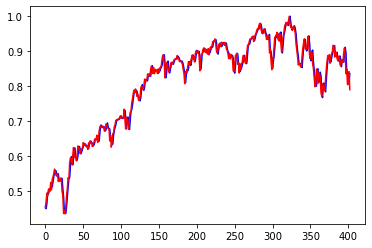

In [92]:
plt.plot(predictions, color = "blue")
plt.plot(test, color = "red")

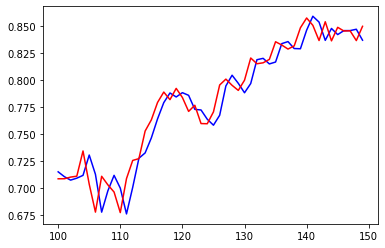

In [91]:
plt.plot(predictions[100:150], color = "blue")
plt.plot(test[100:150], color = "red")